<a href="https://colab.research.google.com/github/melzismn/Digital-Design-2020-2021/blob/master/ShapeLaplacian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ONLY FOR COLAB
# Not required in Binder

!wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

!conda install -q -y --prefix /usr/local python=3.6 ujson

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

import ujson
print(ujson.dumps({1:2}))

!conda install -c conda-forge igl
!conda install -c conda-forge meshplot

In [ ]:
import igl
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
import os 
from sklearn.cluster import KMeans

# Read and visualize meshes

There are several libraries to do Geometry Processing in Python. In this case we will use the python binding of [libigl](https://libigl.github.io/libigl-python-bindings/). Another nice library for 3D visualization is [Open3D](http://www.open3d.org/).

In [ ]:
# Read and plot mesh
v, f = igl.read_triangle_mesh(os.path.join('.', "data", "tr_reg_043.off"))
plot(v, f)

# **Computing the Laplacian and Mass Matrix**

Computing the cotangent matrix requires a bit of work (not really complicate, but boring). In this case we will use some ready methods.

In [ ]:
# Compute Laplacian and Area Matrix
L = -igl.cotmatrix(v, f)
M = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)

# Compute EigenDecomposition
try:
    evals, evecs = eigsh(L, 200, M, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
except:
    evals, evecs = eigsh(L- 1e-8* scipy.sparse.identity(v_src.shape[0]), 200,
                         M, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
    

In [ ]:
# Visualization
plot(v,f,evecs[:,0])

# Coordinate low pass representation

We can use the eigenvectors of the LBO to do a low-pass filtering for functions. A nice function to filter is the coordinates: in fact they can be seen as three functions defined over the vertices. This will give us a low-pass filtering of the surface geometry.

The tasks are:
- Do the synthesis and analysis of the coordinate with a subset of the basis (Warning: remember that the dot product requires also the areas!)
- Perform the filtering with a different number of basis (e.g. 5, 10, 30, 50, ...)

What happens? Which areas are affected and in which way?

In [ ]:
# Coordinate low pass representation
evecs_trim = evecs[:,0:10]
v1 = np.matmul(evecs_trim,np.matmul(evecs_trim.T,csr_matrix.dot(M,v)))
subplot(v1, f, s=[1, 2, 0])

v2 = np.matmul(evecs,np.matmul(evecs.T,csr_matrix.dot(M,v)))
subplot(v2, f, s=[1, 2, 1])

# Spectral Clustering (Segmentation)

As we did for graphs, we can cluster the surface using the spectral embedding of the shapes.

The tasks are:
- Choosing a proper number of clustering
- Running KMeans on a proper number of eigenvectors
- Visualizing the clusters
- Repeat on a second model

How they behave on the human body? Are they coherent among different models? 

In [ ]:
n_c = 6
kmeans = KMeans(n_clusters=n_c, random_state=1).fit(evecs[:,1:n_c])
plot(v, f, kmeans.labels_,shading={"wireframe": False, "colormap": "jet"})

In [ ]:
v2, f2 = igl.read_triangle_mesh(os.path.join('.', "data", "tr_reg_089.off"))
L = -igl.cotmatrix(v2, f2)
M = igl.massmatrix(v2, f2, igl.MASSMATRIX_TYPE_VORONOI)
try:
    evals2, evecs2 = eigsh(L, 200, M, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
except:
    evals2, evecs2 = eigsh(L- 1e-8* scipy.sparse.identity(v_src.shape[0]), 200,
                         M, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
n_c = 6
kmeans2 = KMeans(n_clusters=n_c, random_state=5).fit(evecs2[:,1:n_c])

subplot(v2, f2, kmeans2.labels_,shading={"wireframe": False, "colormap": "jet"},s=[1,2,0]) 
subplot(v, f, kmeans.labels_,shading={"wireframe": False, "colormap": "jet"},s=[1,2,1]) 

**Utility: Plot a couple of meshes togheter** (for the future)

In [ ]:
def plot_pair(v1, v2, f1, f2, c1, c2, color_ops):
    # Compute a scale factor
    M1 = igl.massmatrix(v1, f1, igl.MASSMATRIX_TYPE_VORONOI)
    M2 = igl.massmatrix(v2, f2, igl.MASSMATRIX_TYPE_VORONOI)
    scale_factor = np.sqrt(np.sum(M2)/np.sum(M1))

    # Align the shapes
    v1_align = v1 * scale_factor + np.mean(v2,axis=0) + [0.4,0,0]

    # Merge the models
    v_all = np.vstack((v1_align, v2))
    f_all = np.vstack((f1, f2 + np.max(f)+1))

    c_all = np.hstack((c1, c2))
    plot(v_all, f_all, c_all, shading = color_ops)

In [ ]:
color_ops={"wireframe": False, "colormap": "jet"}
plot_pair(v, v2, f, f2, kmeans.labels_, kmeans2.labels_, color_ops)

**Now try to replicate the results in the slide from the lecture**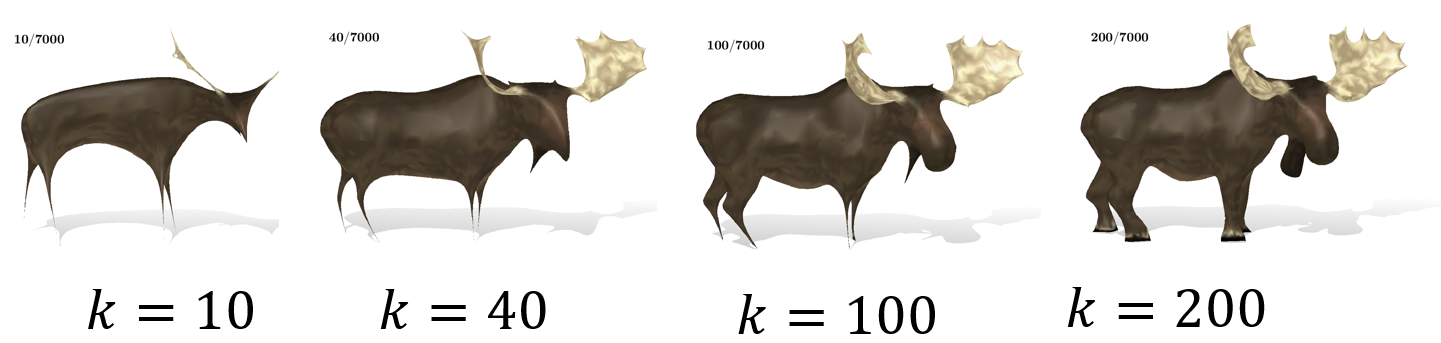

In [ ]:
v, f = igl.read_triangle_mesh(os.path.join('.', "data", "MooseOBJ.obj"))
plot(v, f)